# Digits Dataset Model Comparison

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Get the dataset

Dataset Information:
X: (1797, 64), [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
y: (1797,), [0 1 2 3 4 5 6 7 8 9]


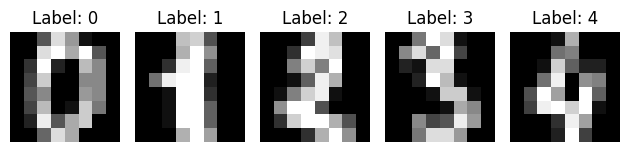

Updated Dataset Information:
X: (1797, 890), [0. 1.]
y: (1797,), [0 1 2 3 4 5 6 7 8 9]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder


# Generate the dataset with specified parameters
digits = load_digits()
X_data, y_data = digits.data, digits.target

# Display dataset information
print("Dataset Information:")
print(f"X: {X_data.shape}, {np.unique(X_data)}")
print(f"y: {y_data.shape}, {np.unique(y_data)}")

# Plot 5 sample images from the dataset
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_data[i].reshape(8, 8), cmap="gray")
    plt.title(f"Label: {y_data[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Convert the dataset to binary classification
X_data = OneHotEncoder(sparse_output=False).fit_transform(X_data)

# Display the updated dataset information
print("Updated Dataset Information:")
print(f"X: {X_data.shape}, {np.unique(X_data)}")
print(f"y: {y_data.shape}, {np.unique(y_data)}")

# Split the dataset into training and testing sets
X_train_np, X_test_np, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# Convert NumPy arrays to Pandas DataFrames
feature_names = [f"feature_{i}" for i in range(X_data.shape[1])]
X_train = pd.DataFrame(X_train_np, columns=feature_names)
X_test = pd.DataFrame(X_test_np, columns=feature_names)

## Evaluate the models

In [3]:
import pickle
from time import perf_counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


def evaluate_model(model, X_train, y_train, X_test, y_test, name=None):
    # Fit the model
    start_time = perf_counter()
    model.fit(X_train, y_train)
    training_time = perf_counter() - start_time

    # Estimate the model size
    model_size = None
    try:
        if name in (
            "Green Tsetlin Classifier",
            "Green Tsetlin Sparse Classifier",
            "C Tsetlin Classifier",
            "GridSearch C Tsetlin Classifier",
        ):
            if isinstance(model, GridSearchCV):
                model_size = model.best_estimator_.estimate_model_size()
            else:
                model_size = model.estimate_model_size()
        else:
            pickled_model = pickle.dumps(model)
            model_size = len(pickled_model)
    except Exception:
        pass

    # Predict on the training set
    start_time = perf_counter()
    y_train_pred = model.predict(X_train)
    prediction_train_time = perf_counter() - start_time

    # Predict on the test set
    start_time = perf_counter()
    y_test_pred = model.predict(X_test)
    prediction_test_time = perf_counter() - start_time

    # Calculate Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # print(f"Model: {name}")
    # print(f"  Training Accuracy: {train_accuracy:.4f}")
    # print(f"  Test Accuracy: {test_accuracy:.4f}")

    if isinstance(model, GridSearchCV):
        print(f"Best parameters for {name}: \n  {model.best_params_}")

    return (
        name,
        train_accuracy,
        test_accuracy,
        training_time,
        prediction_train_time,
        prediction_test_time,
        model_size,
    )

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from tsetlin_machine_py.green_tsetlin_clf import GreenTsetlinClassifier
from tsetlin_machine_py.green_tsetlin_sparse_clf import GreenTsetlinSparseClassifier
from tsetlin_machine_py.c_tsetlin_clf import CTsetlinClassifier

models = [
    (LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression"),
    (DecisionTreeClassifier(random_state=42), "Decision Tree"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (MLPClassifier(max_iter=1000, solver="lbfgs", random_state=42), "MLP Classifier"),
    (SVC(random_state=42), "SVC"),
    (LinearSVC(random_state=42, dual="auto"), "Linear SVC"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (GaussianNB(), "Gaussian Naive Bayes"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting"),
    (LGBMClassifier(random_state=42, verbose=-1), "LightGBM"),
]

# GridSearchCV for RandomForest
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring="accuracy",
    n_jobs=-1,
)
models.append((grid_search_rf, "GridSearch Random Forest"))

# GridSearchCV for MLPClassifier
param_grid_mlp = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001, 0.01],
}
grid_search_mlp = GridSearchCV(
    MLPClassifier(max_iter=1000, solver="lbfgs", random_state=42),
    param_grid_mlp,
    scoring="accuracy",
    n_jobs=-1,
)
models.append((grid_search_mlp, "GridSearch MLP Classifier"))

# Green Tsetlin Classifier
green_tsetlin_clf = GreenTsetlinClassifier(random_state=42)
models.append((green_tsetlin_clf, "Green Tsetlin Classifier"))

# Green Tsetlin Sparse Classifier
green_tsetlin_sparse_clf = GreenTsetlinSparseClassifier(random_state=42)
models.append((green_tsetlin_sparse_clf, "Green Tsetlin Sparse Classifier"))

# C Tsetlin Classifier
c_tsetlin_clf = CTsetlinClassifier(random_state=42)
models.append((c_tsetlin_clf, "C Tsetlin Classifier"))

# GridSearchCV for C Tsetlin Classifier
param_grid_ctsetlin = {
    "threshold": [1000, 2000],
    "num_clauses": [500, 1000, 1500],
}
grid_search_ctsetlin = GridSearchCV(
    CTsetlinClassifier(random_state=42),
    param_grid_ctsetlin,
    scoring="accuracy",
    n_jobs=-1,
)
models.append((grid_search_ctsetlin, "GridSearch C Tsetlin Classifier"))

# Evaluate each model
results_table = PrettyTable()
results_table.field_names = [
    "Model",
    "Training Accuracy",
    "Test Accuracy",
    "Training Time (s)",
    "Prediction Train Time (s)",
    "Prediction Test Time (s)",
    "Model Size (bytes)",
]
for i, (model, name) in enumerate(models):
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name=name)
    results_table.add_row(
        [
            metrics[0],
            f"{metrics[1]:.4f}",
            f"{metrics[2]:.4f}",
            f"{metrics[3]:.4f}",
            f"{metrics[4]:.4f}",
            f"{metrics[5]:.4f}",
            f"{metrics[6]:,}" if metrics[6] else "N/A",
        ]
    )
    print(f"Evaluated {i + 1}/{len(models)}: {name}")

Evaluated 1/16: Logistic Regression
Evaluated 2/16: Decision Tree
Evaluated 3/16: Random Forest
Evaluated 4/16: MLP Classifier
Evaluated 5/16: SVC
Evaluated 6/16: Linear SVC
Evaluated 7/16: K-Nearest Neighbors
Evaluated 8/16: Gaussian Naive Bayes
Evaluated 9/16: Gradient Boosting
Evaluated 10/16: LightGBM
Best parameters for GridSearch Random Forest: 
  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Evaluated 11/16: GridSearch Random Forest
Best parameters for GridSearch MLP Classifier: 
  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Evaluated 12/16: GridSearch MLP Classifier
Evaluated 13/16: Green Tsetlin Classifier
Evaluated 14/16: Green Tsetlin Sparse Classifier
Evaluated 15/16: C Tsetlin Classifier
Best parameters for GridSearch C Tsetlin Classifier: 
  {'num_clauses': 1500, 'threshold': 1000}
Evaluated 16/16: GridSearch C Tsetlin Classifier


In [5]:
# Display the results table
results_table.sortby = "Test Accuracy"
results_table.reversesort = True
# print(results_table)

# Get data from PrettyTable
columns = results_table.field_names
data = results_table.rows

# Create Pandas DataFrame
df = pd.DataFrame(data, columns=columns)

# print("\nResults for Digits dataset:")
display(df)

,Model,Training Accuracy,Test Accuracy,Training Time (s),Prediction Train Time (s),Prediction Test Time (s),Model Size (bytes)
0,Logistic Regression,1.0000,0.9528,1.2750,0.0037,0.0039,"84,514"
1,Decision Tree,1.0000,0.7833,0.0427,0.0055,0.0022,"59,928"
2,Random Forest,1.0000,0.9444,0.1902,0.0148,0.0062,"9,855,780"
3,MLP Classifier,1.0000,0.9306,4.7106,0.0226,0.0360,"1,461,199"
4,SVC,0.9965,0.9583,0.2982,0.4417,0.1130,"9,585,426"
5,Linear SVC,1.0000,0.9472,0.0873,0.0130,0.0104,"84,395"
6,K-Nearest Neighbors,0.9088,0.8667,0.0027,0.0747,0.0087,"10,256,123"
7,Gaussian Naive Bayes,0.9666,0.8278,0.0060,0.0179,0.0051,"155,647"
8,Gradient Boosting,1.0000,0.9139,9.0043,0.0144,0.0051,"1,359,941"
9,LightGBM,1.0000,0.9472,0.5642,0.0083,0.0033,"3,124,964"
